# Computer Vision

## Introduction

- Contributor  : Ghaffar Farros
- Objective : membuat sebuah model Deep Learning dengan menggunakan Computer Vision untuk melakukan klasifikasi apakah pekerja sudah menggunakan safety gear atau belum. Hasil prediksi akan dievaluasi dengan menggunakan precision score untuk meminimalisir false positive (kondisi dimana terdeteksi sudah menggunakan safety attribute, namun sebenarnya tidak pakai). Model akan dibandingkan antara baseline dengan setelah dilakukan improvement.
- Note : Google Colab GPU

### Problem Breakdown

- Latar Belakang:
Dalam industri konstruksi, keselamatan adalah prioritas utama. Memastikan bahwa semua pekerja mematuhi standar keselamatan. Namun, pengawasan manual memerlukan banyak tenaga kerja dan dapat menjadi tidak efisien.

- Masalah:
Pengawasan manual sering kali memerlukan kehadiran petugas K3 yang banyak dan dapat melelahkan. Human error juga dapat berisiko terhadap keselamatan pekerja dan menambah biaya perusahaan.

- Solusi: Sistem Pengawasan Otomatis Berbasis Computer Vision
Model ini dirancang untuk mendeteksi dan mengenali apakah pekerja konstruksi menggunakan helm atau perlindungan keselamatan lainnya. Dengan menggunakan teknologi pemrosesan gambar dan deep learning, model dapat menganalisis video atau gambar dari situs konstruksi dalam waktu nyata.

- Manfaat untuk Bisnis:
  - Efisiensi: Mengurangi kebutuhan untuk pengawasan manual yang intensif dan mengurangi biaya tenaga kerja yang terkait dengan pemantauan kepatuhan keselamatan.
  - Kepatuhan yang Lebih Baik: Meningkatkan kepatuhan terhadap standar keselamatan, pengawasan yang konsisten nonstop.
  - Pengurangan Risiko: Meminimalkan risiko kecelakaan kerja dengan memastikan semua pekerja menggunakan perlindungan yang diperlukan secara real-time.
  - Data dan Analitik: Menyediakan data analitik tentang kepatuhan keselamatan yang dapat digunakan untuk melaporkan kepada pihak berwenang atau untuk evaluasi internal.

### Metrik Evaluasi

Metrik Evaluasi ditetapkan terlebih dahulu karena memegang peranan penting dalam evaluasi hasil prediksi. Pada studi kasus kali ini akan menggunakan metrik **Precision** yang mengukur proporsi dari semua prediksi positif yang benar.

- Alasan: Meminimalisir False Positives di mana model memprediksi positif
- Contoh: Seseorang memakai safety gear, padahal sebenarnya sebenarnya tidak memakai safety gear.

Kasus **False Positive** dalam hal ini merupakan kondisi krusial yang dapat meningkatkan resiko peningkatan kecelakaan kerja yang berdampak pada berbagai hal sehingga penting untuk diminimalisir.


## Import Libraries

In [1]:
%%time
# Import libraries
import os
import cv2
import glob
import random
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report

# Pretrained model
from keras.applications.vgg16 import VGG16, preprocess_input

# Additional
import warnings
warnings.filterwarnings('ignore')

CPU times: user 4.82 s, sys: 582 ms, total: 5.41 s
Wall time: 13.1 s


Melakukan import semual library yang diperlukan dalam proses pembelajaran

## Data Loading

In [2]:
# Connecting Colab & Drive
drive.mount('/content/drive')

# Install Kaggle library
# !pip install kaggle

# Make a directory named `.kaggle`
!mkdir ~/.kaggle

Mounted at /content/drive


In [3]:
## Copy the kaggle.json into this new directory
!cp /content/drive/MyDrive/CVision/kaggle.json ~/.kaggle/

## Change permission for this directory :
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download Dataset
# Source dataset : https://www.kaggle.com/datasets/khananikrahman/is-an-employee-wearing-safety-gear

!kaggle datasets download -d khananikrahman/is-an-employee-wearing-safety-gear

Dataset URL: https://www.kaggle.com/datasets/khananikrahman/is-an-employee-wearing-safety-gear
License(s): apache-2.0
100% 44.0M/44.2M [00:03<00:00, 18.2MB/s]
100% 44.2M/44.2M [00:03<00:00, 11.9MB/s]


In [5]:
# unzip the folder
!unzip -q ./is-an-employee-wearing-safety-gear.zip

In [6]:
# Check folder which contain wearing safety and not
os.listdir('/content/GearedorNot')

['Wearing Safety Gear', 'Not Wearing Safety Gear']

In [7]:
# Define paths
source_dirs = ['/content/GearedorNot/Not Wearing Safety Gear',
               '/content/GearedorNot/Wearing Safety Gear']

#define directory train/test
train_dir = '/content/images/data/train'
test_dir = '/content/images/data/test'

# Create trainand test directories if they don't exist
for dir_path in [train_dir, test_dir]:
    os.makedirs(os.path.join(dir_path, 'Not Wearing Safety Gear'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'Wearing Safety Gear'), exist_ok=True)

# Split ratio for train and test
split_ratio = {'train': 0.8, 'test': 0.2}

# Function to move files
def move_files(source_dir, dest_dir, files):
    for file in files:
        shutil.move(os.path.join(source_dir, file), os.path.join(dest_dir, file))

# Move files into train and test
for source_dir in source_dirs:
    files = os.listdir(source_dir)
    random.shuffle(files)  # Shuffle files to randomize the order

    # Calculate split points
    train_split = int(split_ratio['train'] * len(files))
    test_split = int(split_ratio['test'] * len(files))

    # Split files into train and test
    train_files = files[:train_split]
    test_files = files[train_split:]

    # Move files to respective directories
    move_files(source_dir, os.path.join(train_dir, os.path.basename(source_dir)), train_files)
    move_files(source_dir, os.path.join(test_dir, os.path.basename(source_dir)), test_files)

In [8]:
# Define path
main_path = '/content/images/data'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')

# Check how many data in `train_path` and `test_path`
def check_path(path):
  Labels = os.listdir(path)
  for label in Labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - Wearing Safety Gear : 128
Total Data - Not Wearing Safety Gear : 156

Test Path
Total Data - Wearing Safety Gear : 33
Total Data - Not Wearing Safety Gear : 39



In [9]:
categories = ['Not Wearing Safety Gear', 'Wearing Safety Gear']

# Function to load images from a folder
def load_images_from_folder(folder_path, num_images=8):
    images = []
    for category in categories:
        category_path = os.path.join(folder_path, category)
        for i, filename in enumerate(os.listdir(category_path)):
            if i >= num_images:
                break
            img_path = os.path.join(category_path, filename)
            img = Image.open(img_path)
            img = img.resize((224,224))
            images.append((img, category))
    return images

# Load images from train folder
train_images = load_images_from_folder(os.path.join(main_path, 'train'))
test_images = load_images_from_folder(os.path.join(main_path, 'test'))

Sebelum dilakukan pemrosesan data, dimulai dari persiapan dan data loading dahulu. Perintah diatas dimulai dari menghubungkan Google Colab dengan Drive, menyiapkan Colab dengan data yang ada di Kaggle, Download dan unzip data, membaginya secara merata kedalam data train 80% dan test 20%. Berikut adalah data yang di load:
- Train = 128 Safety & 156 Not Safety
- Test  = 33 Safety & 39 Not Safety

Dalam kasus ini, jumlah data pada dataset relatif kecil, sehingga saya memutuskan untuk tidak membagi data lagi kedalam `validation set` agar tidak mengurangi kemampuannya untuk generalisasi pada data yang belum pernah dilihat. Untuk mengurangi keterbatasan tersebut, maka diterapkan beberapa langkah berikut:
- **Regularisasi dropout** untuk mencegah ketergantungan terhadap salah satu neuron yang dominan
- **Data Augmentation** untuk meningkatkan variasi pelatihan dataset secara artifisial dari beberapa bentuk berbeda
- **Transfer Learning** dengan pre-trained model yang sudah dilatih pada dataset yang lebih besar dan sumberdaya yang lebih mumpuni.

## Exploratory Data Analysis (EDA)

In [10]:
# Function to display images
def display_images(images, title):
    fig, ax = plt.subplots(nrows=2, ncols=8, figsize=(20, 5))
    ax = ax.flatten()

    for i in range(16):  # 8 images per category, 2 categories
        img, category = images[i]
        ax[i].imshow(img)
        ax[i].set_title(category)
        ax[i].axis('off')

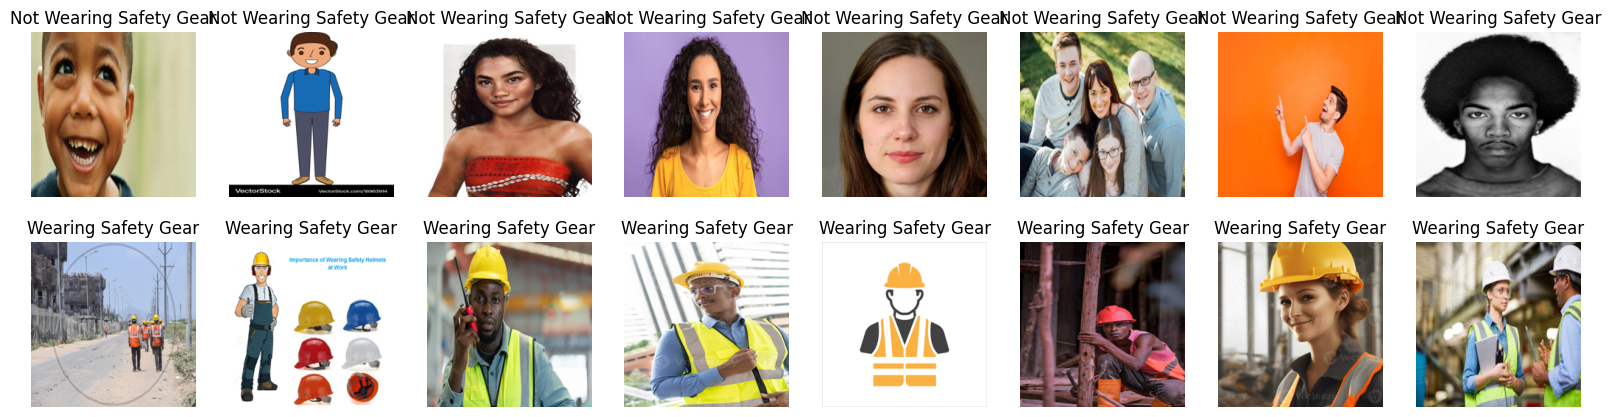

In [11]:
#visualize images in train set
display_images(train_images, 'Train Images')

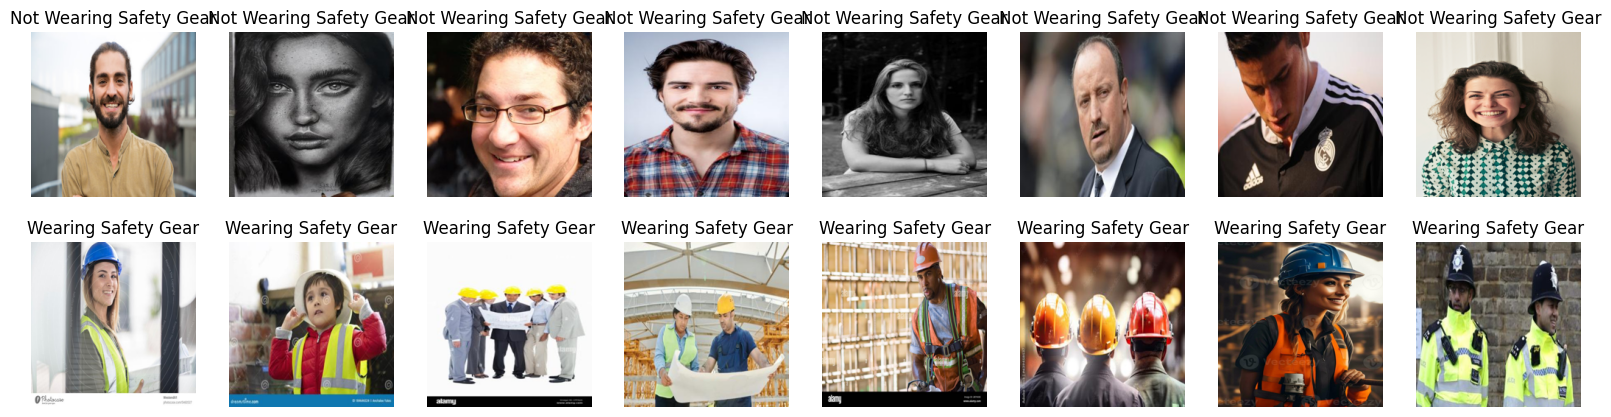

In [12]:
#visualize images in test set
display_images(test_images, 'Test Images')

Plot diatas menunjukkan masing-masing data yang sudah diupload dan siap digunakan untuk pembelajaran. Menampilkan setiap klasifikasi menggunakan safety gear/tidak menggunakan safety gear pada tiap train dan test datanya

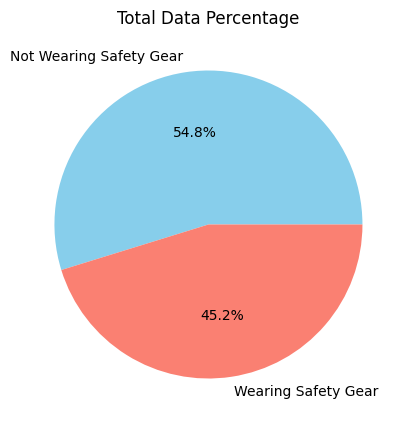

{'Not Wearing Safety Gear': 195, 'Wearing Safety Gear': 161}


In [13]:
# count data
def get_data_counts(path):
    counts = {}
    Labels = os.listdir(path)
    for label in Labels:
        num_data = len(os.listdir(os.path.join(path, label)))
        counts[label] = num_data
    return counts

# Get data counts for train and test paths
train_counts = get_data_counts(train_path)
test_counts = get_data_counts(test_path)

# Combine train and test counts
combined_counts = {label: train_counts.get(label, 0) + test_counts.get(label, 0) for label in set(train_counts) | set(test_counts)}

# Prepare data for plotting
Labels = list(combined_counts.keys())
values = [combined_counts[label] for label in Labels]

# Create the pie chart
fig, ax = plt.subplots(figsize=(5,5))
ax.pie(values, labels=Labels, autopct='%1.1f%%', colors=['skyblue', 'salmon'])

# Add a title
ax.set_title('Total Data Percentage')

plt.show()

# Print the combined counts
print(combined_counts)

Dalam dataset terdapat 195 gambar (54,8%) yang menunjukkan pegawai konstruksi tidak memakai perlindungan keselamatan dan 161 gambar (45,2%) yang menunjukkan pegawai memakai perlindungan keselamatan. Pie chart diatas menunjukkan data yang relatif seimbang antar jumlah kelasnya, sehingga cukup baik proporsinya sebagai pembelajaran.



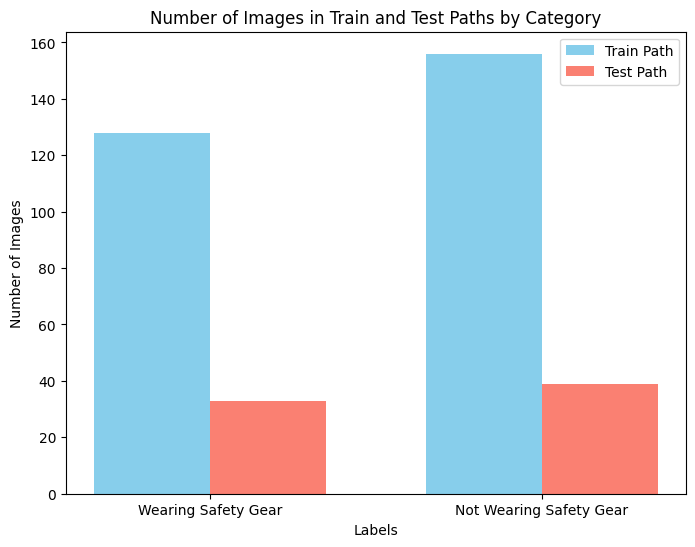

====Train Path====
Total Data - Wearing Safety Gear : 128
Total Data - Not Wearing Safety Gear : 156
====Test Path====
Total Data - Wearing Safety Gear : 33
Total Data - Not Wearing Safety Gear : 39


In [14]:
#func to count
def get_data_counts(path):
    counts = {}
    Labels = os.listdir(path)
    for label in Labels:
        num_data = len(os.listdir(os.path.join(path, label)))
        counts[label] = num_data
    return counts

# Get data counts for train and test paths
train_counts = get_data_counts(train_path)
test_counts = get_data_counts(test_path)

# Prepare data for plotting
Labels = list(train_counts.keys())
train_values = [train_counts[label] for label in Labels]
test_values = [test_counts.get(label, 0) for label in Labels]

x = np.arange(len(Labels))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(8, 6))

# Plot bars
bars1 = ax.bar(x - width/2, train_values, width, label='Train Path', color='skyblue')
bars2 = ax.bar(x + width/2, test_values, width, label='Test Path', color='salmon')

# Add some text for Labels, title and custom x-axis tick Labels, etc.
ax.set_xlabel('Labels')
ax.set_ylabel('Number of Images')
ax.set_title('Number of Images in Train and Test Paths by Category')
ax.set_xticks(x)
ax.set_xticklabels(Labels)
ax.legend()

plt.show()

print('====Train Path====')
check_path(train_path)
print(f'====Test Path====')
check_path(test_path)

Bar chart diatas memvisualisasikan jumlah gambar untuk masing-masing kategori di train dan test, membantu memahami distribusi data yang tersedia untuk pelatihan dan evaluasi model.

## Feature Engineering

Untuk lebih memudahkan tampilan feature engineering pada setiap model yang ingin diuji, maka dimasukkan kedalam preprocessing setiap model

## Model Baseline

### Preprocessing

In [15]:
# Define parameters
img_height= 224
img_width= 224
batch_size= 20
epoch = 20
seed = 20
callbacks = [EarlyStopping(monitor='loss', patience= 3,restore_best_weights=True)]

In [16]:
# Clear session
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [17]:
# Create batch generator for train-set

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

# Create batch generator for test-set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=seed)

Found 283 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [18]:
# Show labels
train_set.class_indices

{'Not Wearing Safety Gear': 0, 'Wearing Safety Gear': 1}

Berikut poin yang diterapkan pada cells diatas:
- Menentukan Epoch = 20
- melakukan pra-pemrosesan gambar. menormalisasi piksel gambar
- Mengubah ukuran gambar ke dimensi yang ditentukan (224x224 piksel) agar konsisten
- Menetapkan mode label sebagai biner, yaitu untuk klasifikasi dua kelas
- Menentukan jumlah data (20) dalam satu batch
- Mengacak urutan gambar dalam setiap epoch untuk meningkatkan keragaman pelatihan.
- Menetapkan seed acak (20) untuk hasil yang konsisten di setiap run.


### Model Definition

In [19]:
# Create Sequential API model
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same',activation='relu',strides=(2, 2), input_shape=(img_height, img_width,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3,3),activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['precision'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 54, 54, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,531,457 (36.36 MB)

 Trainable params: 9,531,457 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

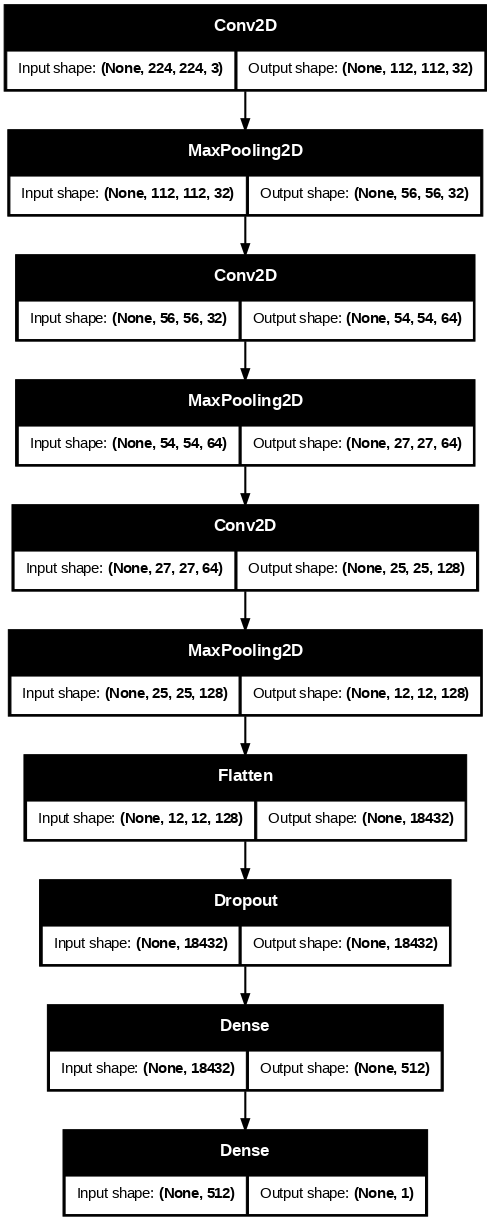

In [20]:
# Plot layers
tf.keras.utils.plot_model(model, show_shapes=True,dpi=75)

Arsitektur:
- Membuat model sekuensial, di mana lapisan-lapisan ditambahkan secara berurutan.
- Lapisan konvolusi dengan 32, 64, dan 128 filter dan ukuran kernel (3,3)
- Stride (2,2) langkah diterapkan pada konvolusi untuk mengurangi ukuran output gambar
- Lapisan pooling maksimum dengan ukuran pool (2,2)
- Padding dimana ukuran output sama dengan input ('same')
- Menggunakan aktivasi 'relu' untuk hasil optimal
- Menggunakan Flatten untuk mengubah output dari lapisan konvolusi menjadi 1D untuk dimasukkan ke lapisan dense.
- Penerapan Regularisasi Dropout dengan rate 50%, untuk mencegah overfitting
- Lapisan dense (fully connected) dengan 512 neuron dan aktivasi 'relu'.
- Dan terakhir adalah Lapisan output dengan 1 neuron dan aktivasi 'sigmoid' untuk output binary

Compilement:
- Binary_crossentropy untuk masalah klasifikasi biner
- Menggunakan algoritma optimisasi adam yang membantu mencapai konvergensi lebih cepat dan stabil
- Metrik evaluasi precision untuk meminimalisir nilai false positive (kondisi dimana terdeteksi sudah menggunakan safety attribute, namun sebenarnya tidak pakai)

### Model Training

In [21]:
# Train the model
history = model.fit(train_set, epochs=epoch, batch_size=batch_size)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 316ms/step - loss: 0.8227 - precision: 0.5377
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.6727 - precision: 0.5295
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.5770 - precision: 0.7565
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - loss: 0.4488 - precision: 0.8094
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.3727 - precision: 0.8260
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.2419 - precision: 0.8997
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.1750 - precision: 0.8955
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.2019 - precision: 0.8550
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0685 - precision: 0.9828
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - loss: 0.0861 - precision: 0.9732
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 0.0423 - precision: 0.9886
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s

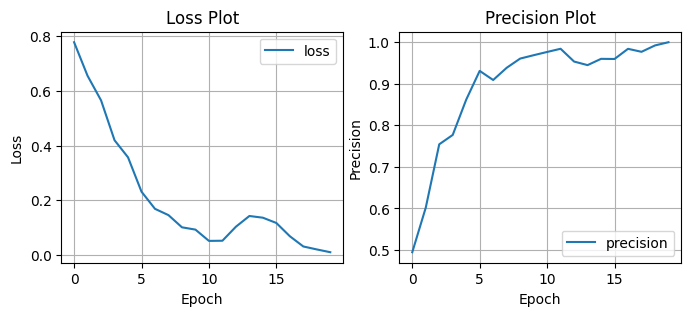

In [22]:
# Plot training results
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Plot')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['precision']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision Plot')
plt.show()

- **Tren Performansi**: Model menunjukkan hasil relatif konsisten dalam hal precision dan penurunan loss pada pelatihan, walaupun terdapat spike pada beberapa bagian. Ini menunjukkan bahwa model belajar cukup baik dari data pelatihan.

- **Resiko Overfitting**: Pada epoch terakhir, metrik evaluasi mencapai 1.0, yang menunjukkan nilai yang sangat baik namun mungkin terlalu sesuai dengan data pelatihan. Ini bisa menjadi indikasi bahwa model mungkin tidak generalisasi dengan baik pada data yang belum terlihat.

Secara keseluruhan, model menunjukkan performa yang sangat baik dalam hal penurunan tren loss maupun kenaikan nilai precision, tetapi perlu diuji lebih lanjut untuk memastikan kinerjanya pada data yang tidak terlihat sebelumnya.

### Model Evaluation

In [23]:
# Get the probability
y_pred = model.predict(test_set)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step


In [24]:
y_pred_class = np.where(y_pred > 0.5,1,0)

In [25]:
print(classification_report(test_set.labels, y_pred_class, target_names=np.array(list(train_set.class_indices.keys()))))

                         precision    recall  f1-score   support

Not Wearing Safety Gear       0.50      0.46      0.48        39
    Wearing Safety Gear       0.42      0.45      0.43        33

               accuracy                           0.46        72
              macro avg       0.46      0.46      0.46        72
           weighted avg       0.46      0.46      0.46        72



- **Overfitting:**

Evaluasi menunjukkan hasil precision score 53% untuk gambar yang tidak menggunakan safety gear dan 43% untuk gambar dengan safety gear. Precision yang lebih rendah di sini mengindikasikan bahwa meskipun pada proses training model mencapai nilai precision yang sangat tinggi pada epoch terakhir (1.0), performa model pada kategori spesifik dalam evaluasi tidak dapat optimal dalam melakukan generalisasi sehingga kesulitan membaca data yang baru.

## Model Improvement

### Augmentation

#### Preprocessing Augmentation

In [26]:
# clear session
tf.keras.backend.clear_session()

# Create batch generator for train-set
train_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                                    rotation_range=30,
                                                                    zoom_range=[0.3, 1.5],
                                                                    width_shift_range=[-100, 100],
                                                                    height_shift_range=[-100, 100],
                                                                    shear_range=0.05,
                                                                    horizontal_flip=True)

train_set_aug = train_datagen_aug.flow_from_directory(train_path,
                                              target_size=(img_height,img_width),
                                              class_mode='binary',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=seed)

# Create batch generator for test-set
test_datagen_aug = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)

test_set_aug = test_datagen_aug.flow_from_directory(test_path,
                                            target_size=(img_height,img_width),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=seed)

Found 283 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


Pada bagian ini data akan terlebih dahulu di dilakukan augmentasi untuk membandingkan dengan hasil sebelumnya, untuk meningkatkan variasi pelatihan dataset secara artifisial dari beberapa posisi maupun bentuk berbeda. berikut perlakukan yang diberikan:
- rotation
- zoom
- width_shift
- height_shift
- shear(potong)
- horizontal_flip

Perlakuan tambahan terhadap data tersebut ditujukan untuk meminimalisir resiko overfitting pada hasil evaluasi dibandingkan sebelumnya.

#### Model Definition Augmentation

In [27]:
# Create Sequential API model_aug
model_aug = Sequential()
model_aug.add(Conv2D(32, (3,3), padding='same',activation='relu',strides=(2, 2), input_shape=(img_height, img_width,3)))
model_aug.add(MaxPooling2D(2, 2))

model_aug.add(Conv2D(64, (3,3), activation='relu'))
model_aug.add(MaxPooling2D(2, 2))

model_aug.add(Conv2D(128, (3,3),activation='relu'))
model_aug.add(MaxPooling2D(2, 2))

model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dense(1, activation='sigmoid'))

# Compile
model_aug.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['precision'])
model_aug.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 112, 112, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 54, 54, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,531,457 (36.36 MB)

 Trainable params: 9,531,457 (36.36 MB)

 Non-trainable params: 0 (0.00 B)

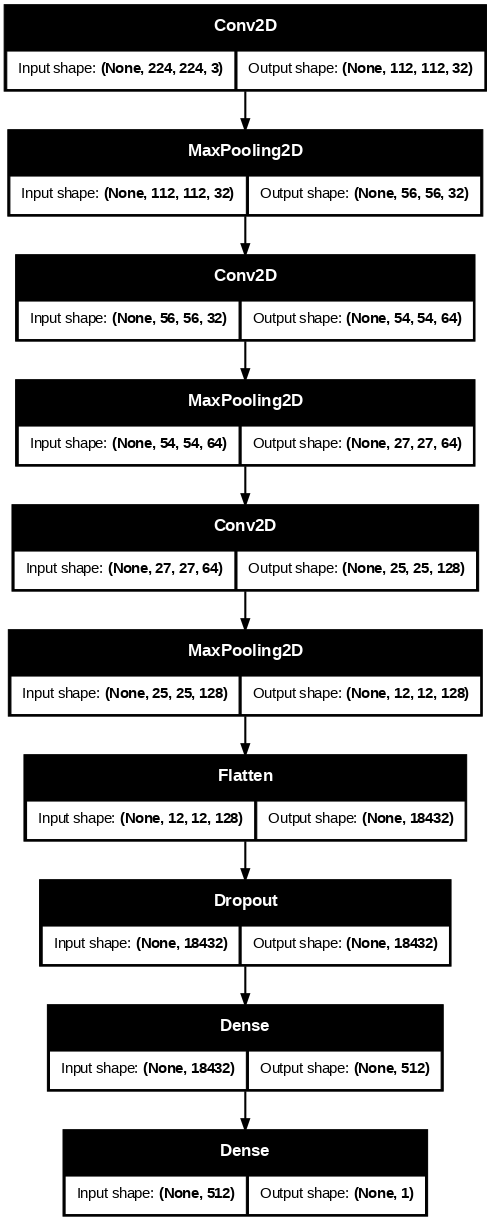

In [28]:
# Plot layers
tf.keras.utils.plot_model(model_aug, show_shapes=True, dpi=75)

Pada bagian arsitektur model tidak dilakukan perubahan, untuk membandingkan apple to apple dengan model sebelumnya.

#### Model Train Augmentation

In [29]:
%%time
# Train the model
history_aug = model_aug.fit(train_set, epochs=epoch, batch_size=batch_size)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 0.7902 - precision: 0.4393
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - loss: 0.5885 - precision: 0.7543
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.5896 - precision: 0.7700
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - loss: 0.3966 - precision: 0.8424
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.3195 - precision: 0.8584
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.1705 - precision: 0.9731
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step - loss: 0.2444 - precision: 0.8894
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.1099 - precision: 0.9457
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 0.0637 - precision: 0.9788
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0494 - precision: 0.9669
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 0.0214 - precision: 1.0000
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5

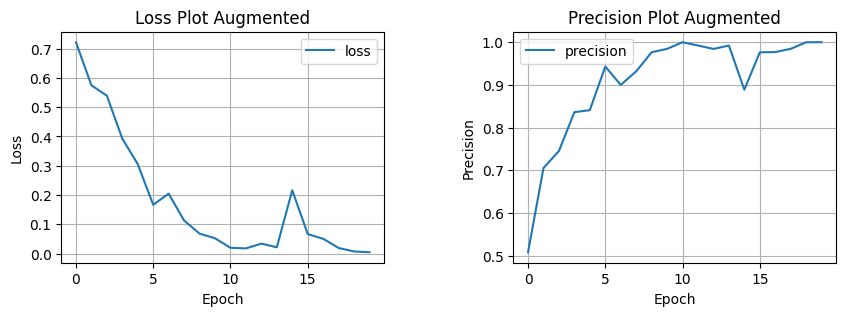

In [30]:
# Plot training results
history_aug_df = pd.DataFrame(history_aug.history)

#comparing before
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
sns.lineplot(data=history_aug_df[['loss']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Loss Plot Augmented')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_aug_df[['precision']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Precision Plot Augmented')
plt.show()

- **Tren Performansi**: Model menunjukkan hasil relatif konsisten dalam hal precision dan penurunan loss pada pelatihan, walaupun terdapat spike pada beberapa bagian. Ini menunjukkan bahwa model belajar cukup baik dari data pelatihan.

- **Resiko Overfitting**: Pada epoch terakhir, metrik evaluasi mencapai 0.98, yang menunjukkan nilai sangat baik dimana model mungkin terlalu sesuai dengan data pelatihan. Dapat menjadi indikasi model sulit dalam melakukan generalisasi nantinya.

Secara keseluruhan berdasarkan hasil dan plot diatas, model menunjukkan performa yang sangat baik dalam hal presisi, maupun penurunan loss, tetapi perlu diuji lebih lanjut untuk memastikan kinerjanya pada data yang tidak terlihat sebelumnya. Hal ini akan dilakukan pada tahap selanjutnya.

#### Model Evaluation Augmentation

In [31]:
# Check the performance of test-set

## Get the probability
y_pred_prob_aug = model_aug.predict(test_set_aug)

## Get class with maximum probability
y_pred_class_aug = np.where(y_pred_prob_aug > 0.5,1,0)

## Display Classification Report
print(classification_report(test_set_aug.classes, y_pred_class_aug, target_names=np.array(list(train_set_aug.class_indices.keys()))))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 327ms/step
                         precision    recall  f1-score   support

Not Wearing Safety Gear       0.77      0.85      0.80        39
    Wearing Safety Gear       0.79      0.70      0.74        33

               accuracy                           0.78        72
              macro avg       0.78      0.77      0.77        72
           weighted avg       0.78      0.78      0.78        72



- **Overfitting:**

Evaluasi menunjukkan hasil precision score 94% untuk gambar yang tidak menggunakan safety gear dan 86% untuk gambar dengan safety gear. Precision yang lebih rendah di sini mengindikasikan bahwa meskipun pada proses training model mencapai nilai precision yang sangat tinggi pada epoch terakhir 98%.

Namun pada proses kalin ini menghasilkan perbaikan. Dengan augmentasi data ini memperbaiki sangat baik dari hasil sebelumnya dengan rentang berikut:
- Kenaikan precision antara model pertama dan kedua adalah 27%.
- Kenaikan  precision antara kategori pertama dan kedua adalah 37%.

Model dengan Augmentasi berhasil memprediksi data yang belum dilihat sebelumnya 27-37% lebih baik daripada sebelumnya.

### Transfer Learning

#### Preprocessing TL

In [32]:
# clear session
tf.keras.backend.clear_session()

input_tensor = Input(shape=(img_height, img_width, 3))
pretrained_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
pretrained_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [33]:
# Create batch generator for train-set

train_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                                   zoom_range=0.05,
                                                                   width_shift_range=0.05,
                                                                   height_shift_range=0.05,
                                                                   shear_range=0.05,
                                                                   horizontal_flip=True,
                                                                   preprocessing_function=preprocess_input)

train_set_tl = train_datagen_tl.flow_from_directory(train_path,
                                                    target_size=(img_height,img_width),
                                                    class_mode='binary',
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    seed=seed)

# Create batch generator for Test-set

test_datagen_tl = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

test_set_tl = test_datagen_tl.flow_from_directory(test_path,
                                                  target_size=(img_height,img_width),
                                                  class_mode='binary',
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  seed=seed)

Found 283 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


#### Model Definition TL

In [34]:
# Define input tensor
input_tensor = Input(shape=(img_height, img_width, 3))

# Load pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False  # Freeze the base model

# Add custom layers on top
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
output_tensor = Dense(1, activation='sigmoid')(x)

# Create model
model_tl = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model_tl.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=[tf.keras.metrics.Precision()])

model_tl.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

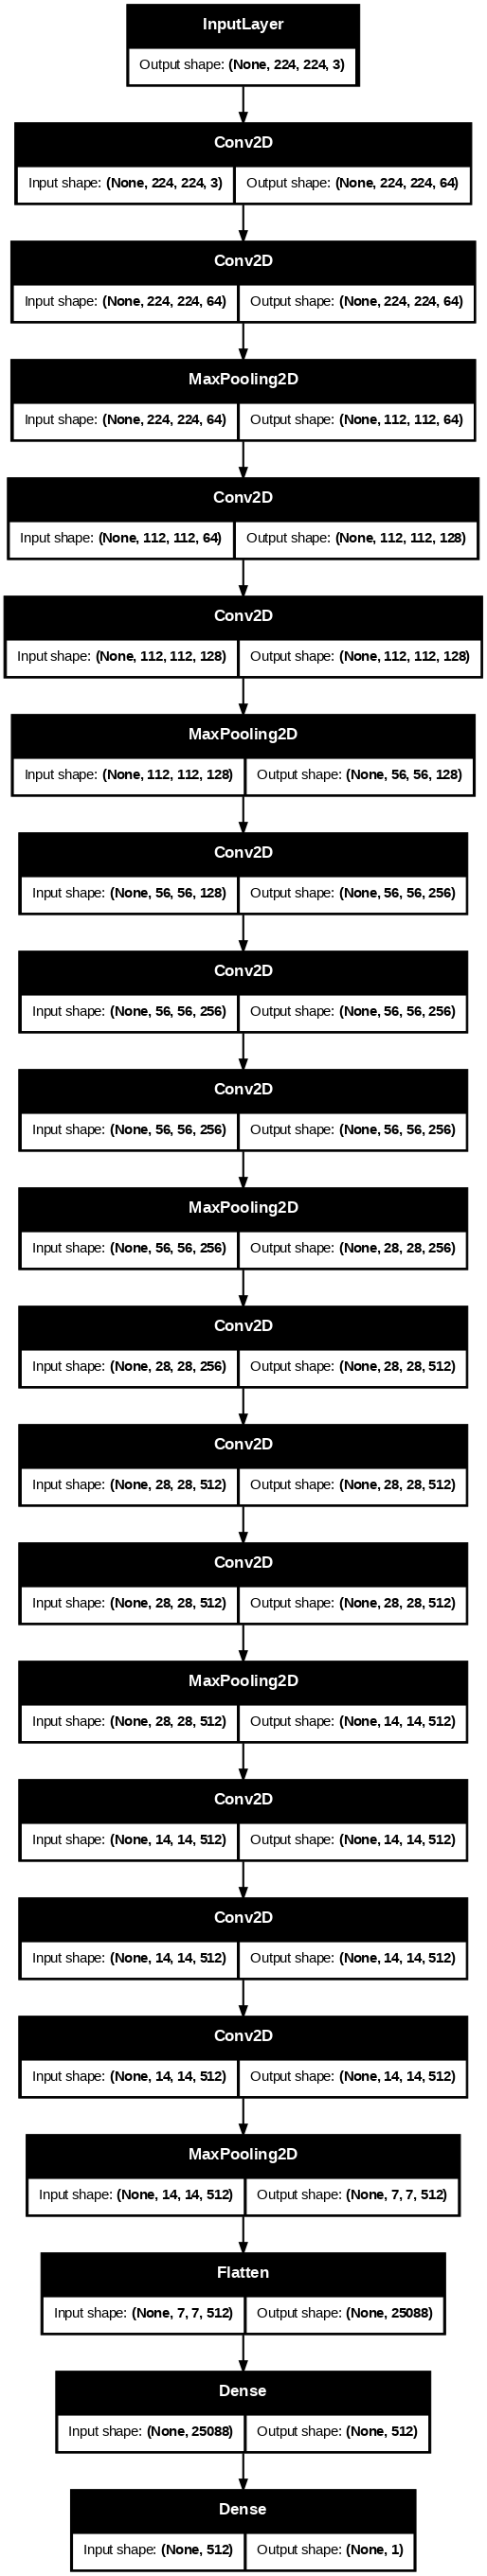

In [35]:
# Plot layers
tf.keras.utils.plot_model(model_tl, show_shapes=True, dpi=75)

Berikut merupakan arsitektur yang dibuat pada penggunaan pretrained model ini:
- Arsitektur kali ini melibatkan model VGG16 yang telah dilatih sebelumnya dengan bobot dari ImageNet.
- include_top=False agar idak menyertakan lapisan fully connected di bagian akhir dari model VGG16, memungkinkan kita untuk menambahkan lapisan khusus
- Membekukan lapisan model dasar sehingga bobotnya tidak diperbarui selama pelatihan
- Mengubah output 2D dari model dasar menjadi 1D dengan flatten untuk masuk ke dense
- Menambahkan lapisan fully connected dengan 512 neuron dan aktivasi ReLU.
- Output layer dengan 1 neuron dan aktivasi sigmoid untuk klasifikasi binary.
- Compilement masih sama

#### Model Train TL

In [36]:
# Train the model

%%time
history_tl = model_tl.fit(train_set_tl, epochs=epoch, batch_size=batch_size, callbacks = callbacks)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 978ms/step - loss: 15.9483 - precision: 0.6807
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - loss: 2.5194 - precision: 0.9956
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - loss: 0.4967 - precision: 0.9673
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 263ms/step - loss: 0.4470 - precision: 0.9858
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - loss: 0.0180 - precision: 1.0000
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - loss: 0.3359 - precision: 0.9827
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - loss: 3.6447e-07 - precision: 1.0000
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 390ms/step - loss: 0.0091 - precision: 0.9985
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - loss: 0.0192 - precision: 0.9980
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - loss: 2.0816e-09 - precision: 1.0000
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - loss: 6.5291e-10 - precision: 1.0000
Epoch 12/20
15/15 ━━━━

In [37]:
# Define to df
history_tl = pd.DataFrame(history_tl.history)

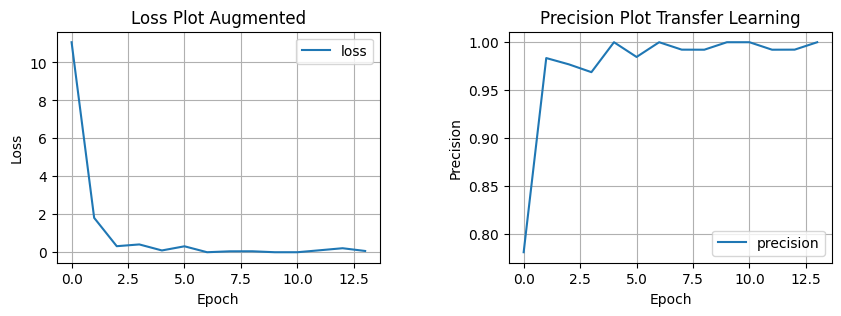

In [38]:
# Plotting
plt.figure(figsize=(10,3))

plt.subplot(1, 2, 1)
sns.lineplot(data=history_tl[['loss']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Loss Plot Augmented')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_tl[['precision']])
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.title('Precision Plot Transfer Learning')
plt.show()

**- Tren Performansi**: Model menunjukkan hasil sangat baik dalam kenaikan precision dan penurunan loss pada pelatihan. Tidak seperti beberapa model sebelumnya, kali ini model dapat dengan cepat menyentuh titik konvergen pada beberapa epoch awal

**- Resiko Overfitting**: Pada epoch 14/20 nilai precision adalah 1.0, yang menunjukkan nilai yang sangat baik namun mungkin terlalu sesuai dengan data pelatihan. Ini bisa menjadi indikasi bahwa model mungkin tidak generalisasi dengan baik pada data yang belum terlihat.

Dalam percobaan kali ini epoch berhenti pada epoch ke-14 yang artinya pada epoch tersebut, nilai loss sudah jenuh dan tidak menunjukkan perbaikan signifikan. Secara keseluruhan, model menunjukkan performa yang sangat baik dalam hal presisi, namun perlu dianalisis lebih lanjut dengan data test yang akan dicek selanjutnya

#### Model Evaluation TL

In [39]:
# Check the performance of test-set

## Get the probability
y_pred_prob_tl = model_tl.predict(test_set_tl)

## Get class with maximum probability
y_pred_class_tl = np.where(y_pred_prob_tl > 0.5,1,0)

## Display Classification Report
print(classification_report(test_set_tl.classes, y_pred_class_tl, target_names=np.array(list(train_set_tl.class_indices.keys()))))

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
                         precision    recall  f1-score   support

Not Wearing Safety Gear       0.95      1.00      0.97        39
    Wearing Safety Gear       1.00      0.94      0.97        33

               accuracy                           0.97        72
              macro avg       0.98      0.97      0.97        72
           weighted avg       0.97      0.97      0.97        72



- **Goodfit:**

Secara keseluruhan model menghasilkan hasil precision yang baik. Evaluasi menunjukkan hasil precision score 0.95 untuk gambar yang tidak menggunakan safety gear dan 1.00 untuk gambar dengan safety gear. Model dapat mengenali data dengan baik pada kasus ini sesuai dengan nilai precision pada hasil train.

Secara garis besar, model yang menggunakan transfer learning menghasilkan nilai dan indikator-indikator yang lebih optimal, sehingga model ini yang nantinya akan disimpan dan digunakan untuk dites pada data inference maupun deployment

---

## Model Saving

In [40]:
# save the best model
model_path = '/content/drive/MyDrive/CVision/model_tl.keras'
model_tl.save(model_path)

## Model Inference

Model Inference dilakukan pada file notebook terpisah `P2G7_Ghaffar_Farros_Inference.ipynb`

## Conclusion
- Program bertujuan menentukan klasifikasi apakah pekerja sudah sesuai standar dengan menggunakan safety gear, atau tidak
- Dataset berisi 356 data dengan pembagian `Not Wearing Safety Gear`: 195 (54,8%) dan `Wearing Safety Gear`: 161 (45,2%). Secara persentase, jumlah untuk target ini cukup baik mengingat perlu seimbang antar kelas.
- Metrik evaluasi yang digunakan adalah Precision, yang mengukur proporsi prediksi positif yang benar. Fokus pada Precision penting untuk meminimalisir False Positives, kondisi dimana model salah memprediksi seseorang memakai safety gear padahal sebenarnya tidak. Mengurangi False Positives krusial untuk mengurangi risiko kecelakaan kerja.
- Modeling dilakukan dengan 3 perlakuan yaitu baseline model, augmented, dan transfer learning:
  - **Base** : Performa relatif konsisten dengan penurunan loss dan peningkatan precision selama pelatihan, terdapat spike di beberapa bagian. Evaluasi menunjukkan hasil overfitting antara train dengan testnya
  - **Augmented** : Performa relatif konsisten dengan penurunan loss dan peningkatan precision selama pelatihan. Evaluasi menunjukkan terjadi perbaikan yang cukup signifikan dari nilai precision sekitar 27-37% namun masih dalam kategori overfitting.
  - **Transfer Learning** : Performa train dengan cepat mencapai hasil maksimal pada epoch awal baik pada loss maupun precision. Data test juga mencapai kenaikan yang signifikan dengan nilai yang dapat dikategorikan sebagai goodfit. Model ini menghasilkan nilai yang paling baik sehingga akan disimpan dan digunakan untuk langkah selanjutnya.

## Recommendation:
- Pada proses modeling dapat melakukan tuning regularisasi untuk mengurangi risiko overfitting, melakukan tuning pada hyper parameter, maupun merubah arsitektur model dengan beragam trial-error.
- Salah satu kekurangan dalam kasus ini adalah dataset yang relatif kecil, yang dapat berpengaruh ke pembelajaran model.Sehingga penting dilakukan pelatihan dengan data train yang lebih besar dan juga relevan dengan suasana ataupun lingkungan konstruksi.
- Pada penerapannya, perlu memasang sistem di beberapa lokasi konstruksi dengan kamera yang strategis untuk memaksimalkan cakupan area.
- Melakukan pemeliharaan secara berkala memperbarui model dan sistem untuk menyesuaikan dengan kondisi dan jenis perlindungan keselamatan baru yang mungkin digunakan di lokasi konstruksi.